In [1]:
from src.flatsky.fibonacci_patch import fibonacci_grid_on_sphere

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [6]:
patch_size = 10
nside = 8192
save_dir = '/lustre/work/akira.tokiwa/Projects/LensingSSC/img/configure'

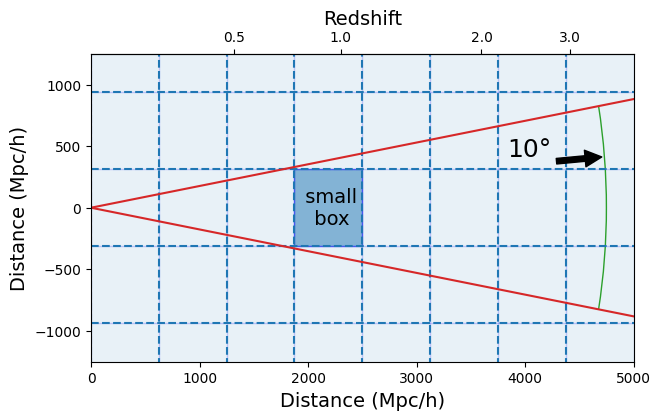

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.cosmology import z_at_value

# Parameters
box_length = 5000  # Mpc/h
replications = 8
opening_angle_deg = 10

# Cosmological parameters
HUBBLE_CONSTANT = 0.6774
OMEGA_MATTER = 0.3090
cosmo = FlatLambdaCDM(H0=HUBBLE_CONSTANT * 100, Om0=OMEGA_MATTER)

# Calculate total length in the line of sight
total_length = 625 * replications  # Mpc/h

# Convert opening angle to radians
opening_angle_rad = np.deg2rad(opening_angle_deg)

# Calculate the extent of the light cone in x and y directions
extent = total_length * np.tan(opening_angle_rad)

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 4))

# Draw the replicated boxes
for i in range(replications):
    ax.vlines(x=i * 625, ymin=-box_length / 2, ymax=box_length / 2, color='tab:blue', linestyle='--')

for i in range(4):
    ax.hlines(y=(i+0.5) * 625, xmin=0, xmax=box_length, color='tab:blue', linestyle='--')
    ax.hlines(y=-(i+0.5) * 625, xmin=0, xmax=box_length, color='tab:blue', linestyle='--')

for i in range(replications):
    for j in range(4):
        rect = plt.Rectangle((i * 625, -625/2 + j * 625), 625, 625, edgecolor='blue', linestyle='-', fill=True, alpha=0.1)
        ax.add_patch(rect)
        if j != 0:
            rect = plt.Rectangle((i * 625, -625/2 - j * 625), 625, 625, edgecolor='blue', linestyle='-', fill=True, alpha=0.1)
            ax.add_patch(rect)

rect = plt.Rectangle((3 * 625, -625/2), 625, 625, edgecolor='blue', linestyle='-', fill=True, alpha=0.5)
ax.add_patch(rect)
ax.text(3 * 625 + 625/2, 0, ' small\n box', fontsize=14, color='black', ha='center', va='center')
    
# Draw the light cone
x_coords = [0, total_length]
y_coords = [0, extent]
ax.plot(x_coords, y_coords, color='tab:red')

x_coords = [0, total_length]
y_coords = [0, -extent]
ax.plot(x_coords, y_coords, color='tab:red')

# Add the opening angle arc
arc = Arc((0, 0), width=total_length*1.9, height=1.9*total_length, angle=0,
          theta1=-opening_angle_deg, theta2=opening_angle_deg, color='tab:green')
ax.add_patch(arc)

# Add the opening angle annotation
arc_radius = total_length*0.95
arc_x = arc_radius * np.cos(opening_angle_rad / 2)
arc_y = arc_radius * np.sin(opening_angle_rad / 2)
ax.annotate(f'{opening_angle_deg}°',
            xy=(arc_x, arc_y),
            xytext=(arc_x - 900, arc_y - 0),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=18,
            color='black')

# Set limits and labels
ax.set_xlim(0, total_length)
ax.set_ylim(-box_length / 4, box_length / 4)
ax.set_xlabel('Distance (Mpc/h)', fontsize=14)
ax.set_ylabel('Distance (Mpc/h)', fontsize=14)
#ax.set_title('Concept Figure of a Light Cone Configuration')


# Create a secondary x-axis for redshift
secax = ax.secondary_xaxis('top')
secax.set_xlabel('Redshift', fontsize=14)
redshift_ticks = [0.5, 1.0, 2.0, 3.0]
distance_ticks = [cosmo.comoving_distance(z).value * HUBBLE_CONSTANT for z in redshift_ticks]
secax.set_xticks(distance_ticks)
secax.set_xticklabels(redshift_ticks)

# save the figure
plt.savefig(f'{save_dir}/light_cone_configuration.png', bbox_inches='tight')

# Functions

In [2]:
from scipy.spatial import cKDTree

def fibonacci_grid_on_sphere(N):
    """
    Generate an array of points on a Fibonacci grid on a sphere.

    Parameters:
    N (int): Number of points to distribute on the sphere.

    Returns:
    np.ndarray: Array of shape (N, 2) where each row contains (theta, phi) coordinates of a point.
    """
    points = np.zeros((N, 2))
    
    phi = (np.sqrt(5) + 1) / 2  # Golden ratio
    golden_angle = 2 * np.pi / phi
    
    for i in range(N):
        theta = np.arccos(1 - 2 * (i + 0.5) / N)
        phi = (golden_angle * i) % (2 * np.pi)
        points[i] = [theta, phi]
    
    return points

def spherical_distance(theta1, phi1, theta2, phi2):
    """
    Calculate the great-circle distance between two points on a sphere given their spherical coordinates.
    """
    delta_phi = phi2 - phi1
    return np.arccos(np.sin(theta1) * np.sin(theta2) + np.cos(theta1) * np.cos(theta2) * np.cos(delta_phi))

def find_optimal_N(min_distance, initial_N=400):
    N = initial_N
    while True:
        points_spherical = fibonacci_grid_on_sphere(N)
        
        # Convert to Cartesian coordinates for KDTree (not for distance calculations)
        points_cartesian = np.array([
            [np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)] 
            for theta, phi in points_spherical
        ])
        
        # Create a KDTree for finding nearest neighbors
        tree = cKDTree(points_cartesian)
        
        # Find the indices of the nearest neighbors
        _, indices = tree.query(points_cartesian, k=2)
        
        # Calculate spherical distances
        nearest_distances = [
            spherical_distance(points_spherical[i][0], points_spherical[i][1], 
                               points_spherical[indices[i][1]][0], points_spherical[indices[i][1]][1])
            for i in range(N)
        ]
        
        min_distance_found = np.min(nearest_distances)
        
        if min_distance_found > min_distance:
            break
        
        N -= 2  # Increment N and try again
    
    return N, points_spherical, nearest_distances

In [3]:
def vertices_from_center(center, patch_size):
    """
    Generate the vertices of a patch centered at a given point on the sphere.
    
    Parameters:
    center (np.ndarray): Array of shape (2,) containing the (theta, phi) coordinates of the center of the patch.
    patch_size (float): Size of the patch in degrees.
    
    Returns:
    np.ndarray: Array of shape (4, 2) containing the (theta, phi) coordinates of the vertices of the patch.
    """
    theta, phi = center
    half_size = np.radians(patch_size) / np.sqrt(2)
    
    vertices = np.array([
        [theta, phi + half_size * np.sin(theta)],
        [theta + half_size, phi],
        [theta, phi - half_size  * np.sin(theta)],
        [theta - half_size, phi]
    ])
    
    return vertices

In [4]:
import math

def M(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def spherical_to_cartesian(theta, phi, r=1):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi

def rotation_matrix(theta, phi):
    """
    Generate a rotation matrix for rotating a point on the sphere by theta and phi.
    """
    R_phi = M([0, 0, 1], phi)
    R_theta = M(np.array([np.sin(phi), -np.cos(phi), 0]), np.pi/2 - theta)
    return np.dot(R_theta, R_phi)

def rotate_point(point, theta, phi):
    """
    Rotate a point on the sphere by theta and phi.
    """
    x, y, z = spherical_to_cartesian(*point)
    x_rot, y_rot, z_rot = np.dot(rotation_matrix(theta, phi), np.array([x, y, z]))
    return cartesian_to_spherical(x_rot, y_rot, z_rot)[1:]

def rotated_vertices(center, patch_size):
    """
    Generate the vertices of a patch centered at a given point on the sphere, rotated by theta and phi.
    """
    theta, phi = center
    vertices = vertices_from_center([np.pi/2, 0], patch_size)
    rotated_vertices = np.array([rotate_point(vertex, theta, phi) for vertex in vertices])
    return rotated_vertices

# Plot

In [24]:
points = fibonacci_grid_on_sphere(N=273)
radius = np.radians(patch_size)* np.sqrt(2)

tmp = np.zeros(hp.nside2npix(nside))

pixels = []
for center in points[(points[:, 0] < np.pi - radius) & (points[:, 0] > radius)]:
    vertices = rotated_vertices(center, patch_size)
    vecs = hp.ang2vec(vertices[:, 0], vertices[:, 1])

    ipix = hp.query_polygon(nside=nside, vertices=vecs, nest=True)
    tmp[ipix] += 1
    pixels.append(len(ipix))

for center in points[(points[:, 0] > np.pi - radius) | (points[:, 0] < radius)]:
    vertices = rotated_vertices(center, patch_size)
    vecs = hp.ang2vec(vertices[:, 0], vertices[:, 1])

    ipix = hp.query_polygon(nside=nside, vertices=vecs, nest=True)
    tmp[ipix] -= 1
    pixels.append(len(ipix))

#ipix_pole = hp.query_disc(nside=nside, vec=hp.ang2vec(0, 0), radius=radius/2, nest=True)
#tmp[ipix_pole] -= 1

#ipix_pole = hp.query_disc(nside=nside, vec=hp.ang2vec(np.pi, 0), radius=radius/2, nest=True)
#tmp[ipix_pole] -= 1

print(len(points))

273


In [29]:
# データの読み込み
data = tmp

# ファイル名の定義
fibonacci_grid_filename = f'{save_dir}/fibonacci_grid.png'
top_view_filename = f'{save_dir}/fibonacci_grid_top_view.png'

# Fibonacciグリッドのプロット
hp.orthview(data, title=r'Fibonacci grid (10x10 $deg^2$), 273 Patch', nest=True, half_sky=True, cbar=False, cmap='viridis')
plt.savefig(fibonacci_grid_filename, bbox_inches='tight')
plt.close()

# トップビューのプロット
hp.orthview(data, title='Top view', nest=True, rot=(0, 90, 0), half_sky=True, cbar=False, cmap='viridis')
plt.savefig(top_view_filename, bbox_inches='tight')
plt.close()

# Optimization

In [ ]:
radius = np.radians(patch_size)* np.sqrt(2) *1.1

def optimal_N(patch_size, N=280):
    flag = True
    radius = np.radians(patch_size) * np.sqrt(2)
    while flag:
        print("testing N = ", N)
        points = fibonacci_grid_on_sphere(N)
        counts = np.zeros(hp.nside2npix(nside))
        for center in points[(points[:, 0] < np.pi - radius) & (points[:, 0] > radius)]:
            vertices = rotated_vertices(center, patch_size)
            vecs = hp.ang2vec(vertices[:, 0], vertices[:, 1])
            ipix = hp.query_polygon(nside=nside, vertices=vecs, nest=True)
            counts[ipix] += 1
            if np.any(counts[ipix] > 1):
                N -= 10
                break
        if np.all(counts[ipix] <= 1):
            flag = False
    return N


N = optimal_N(patch_size)

testing N =  280
testing N =  270
